# SRGAN

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import os

os.getcwd()

'/content'

In [ ]:
#cd to folder 
os.chdir(r'/content/gdrive/My Drive/Kaiyuan/Week 2')



In [ ]:
import os
import matplotlib.pyplot as plt

from data import DIV2K
from model.srgan import generator, discriminator
from train import SrganTrainer, SrganGeneratorTrainer

%matplotlib inline

In [ ]:
# Location of model weights (needed for demo)
weights_dir = 'weights-srgan/weights/srgan'
weights_file = lambda filename: os.path.join(weights_dir, filename)

os.makedirs(weights_dir, exist_ok=True)

## Datasets

You don't need to download the DIV2K dataset as the required parts are automatically downloaded by the `DIV2K` class. By default, DIV2K images are stored in folder `.div2k` in the project's root directory.

In [ ]:
div2k_train = DIV2K(scale=4, subset='train', downgrade='bicubic')
div2k_valid = DIV2K(scale=4, subset='valid', downgrade='bicubic')

In [ ]:
train_ds = div2k_train.dataset(batch_size=16, random_transform=True)
valid_ds = div2k_valid.dataset(batch_size=16, random_transform=True, repeat_count=1)

## Training

### Pre-trained models

If you want to skip training and directly run the demo below, download [weights-srgan.tar.gz](https://drive.google.com/open?id=1u9ituA3ScttN9Vi-UkALmpO0dWQLm8Rv) and extract the archive in the project's root directory. This will create a folder `weights/srgan` containing the weights of the pre-trained models.

### Generator pre-training

In [ ]:
pre_trainer = SrganGeneratorTrainer(model=generator(), checkpoint_dir=f'.ckpt/pre_generator')


Model restored from checkpoint at step 2390.


In [ ]:
pre_trainer.train(train_ds,
                  valid_ds.take(10),
                  steps=2500, 
                  evaluate_every=10, 
                  save_best_only=False)

Start Training=====
2498/2500: loss = 222.169, PSNR = 28.208212 (11.54s)
2499/2500: loss = 369.554, PSNR = 26.834499 (1.75s)
2500/2500: loss = 368.509, PSNR = 25.274586 (1.73s)


In [ ]:

pre_trainer.model.save_weights(weights_file('pre_generator_trial1.h5'))

### Generator fine-tuning (GAN)

In [ ]:
gan_generator = generator()
gan_generator.load_weights(weights_file('pre_generator_trial1.h5'))

gan_trainer = SrganTrainer(generator=gan_generator, discriminator=discriminator())
gan_trainer.train(train_ds, steps=10)

KeyboardInterrupt: ignored

In [ ]:
gan_trainer.generator.save_weights(weights_file('gan_generator_trial1.h5'))
gan_trainer.discriminator.save_weights(weights_file('gan_discriminator_trial1.h5'))

## Demo

In [ ]:
pre_generator = generator()
gan_generator = generator()

pre_generator.load_weights(weights_file('pre_generator_trial1.h5'))
gan_generator.load_weights(weights_file('gan_generator_trial1.h5'))

In [ ]:
from model import resolve_single
from utils import load_image

def resolve_and_plot(lr_image_path):
    lr = load_image(lr_image_path)
    
    pre_sr = resolve_single(pre_generator, lr)
    gan_sr = resolve_single(gan_generator, lr)
    
    plt.figure(figsize=(20, 20))
    
    images = [lr, pre_sr, gan_sr]
    titles = ['LR', 'SR (PRE)', 'SR (GAN)']
    positions = [1, 3, 4]
    
    for i, (img, title, pos) in enumerate(zip(images, titles, positions)):
        plt.subplot(2, 2, pos)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])

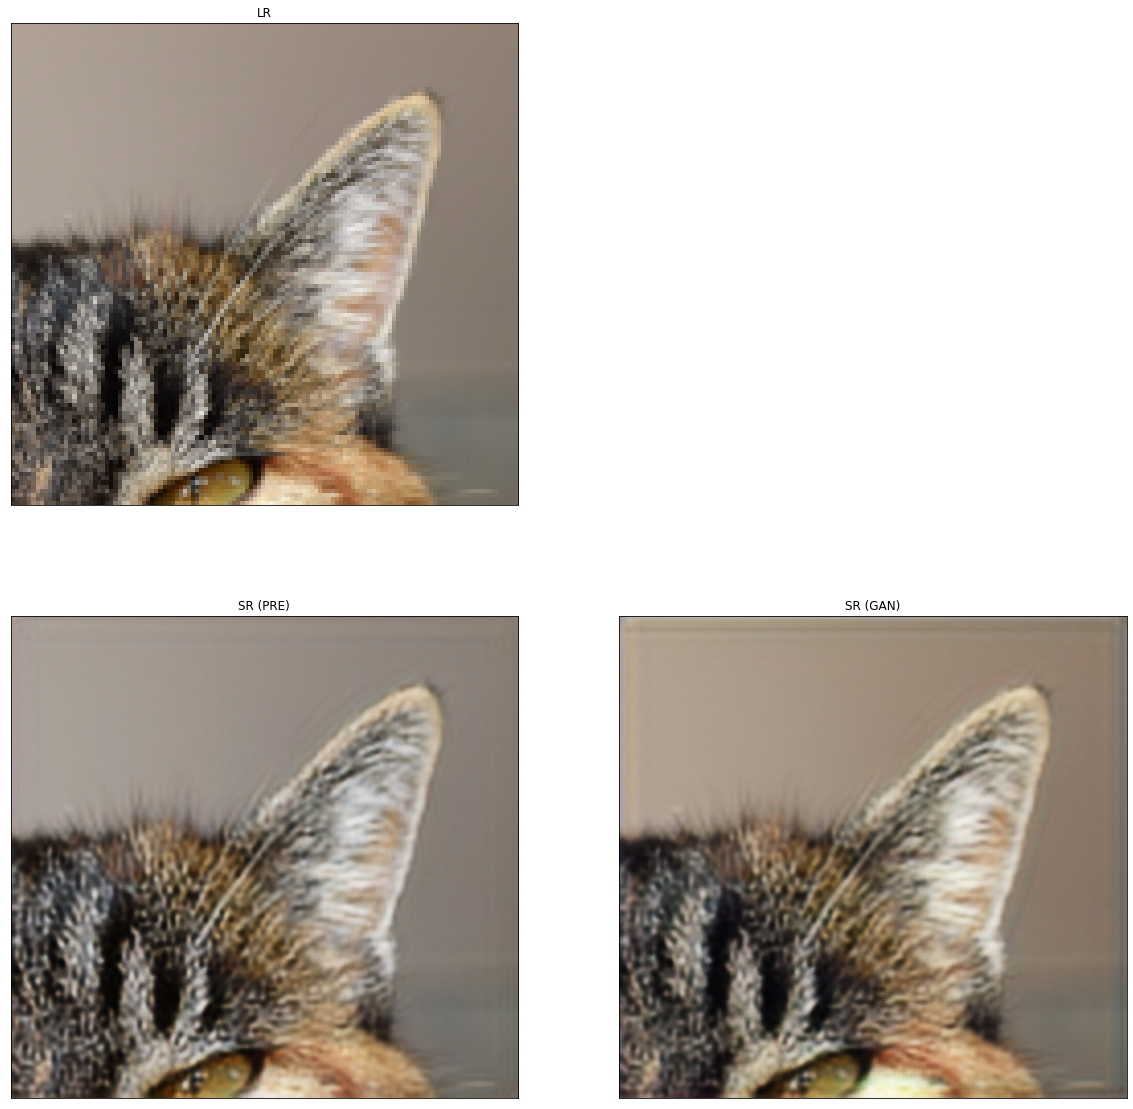

In [ ]:
resolve_and_plot('demo/0869x4-crop.png')

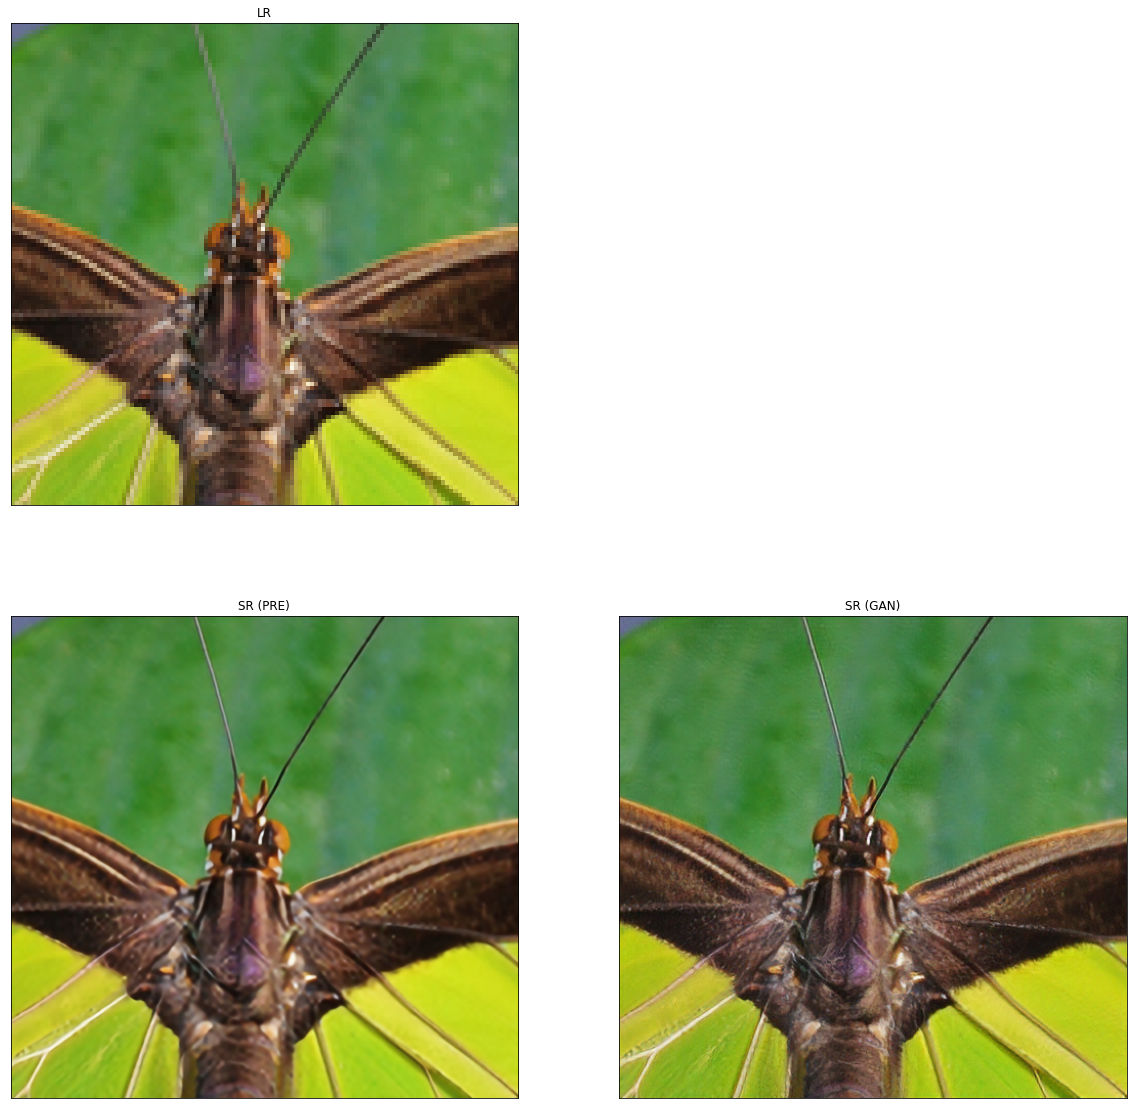

In [ ]:
resolve_and_plot('demo/0829x4-crop.png')

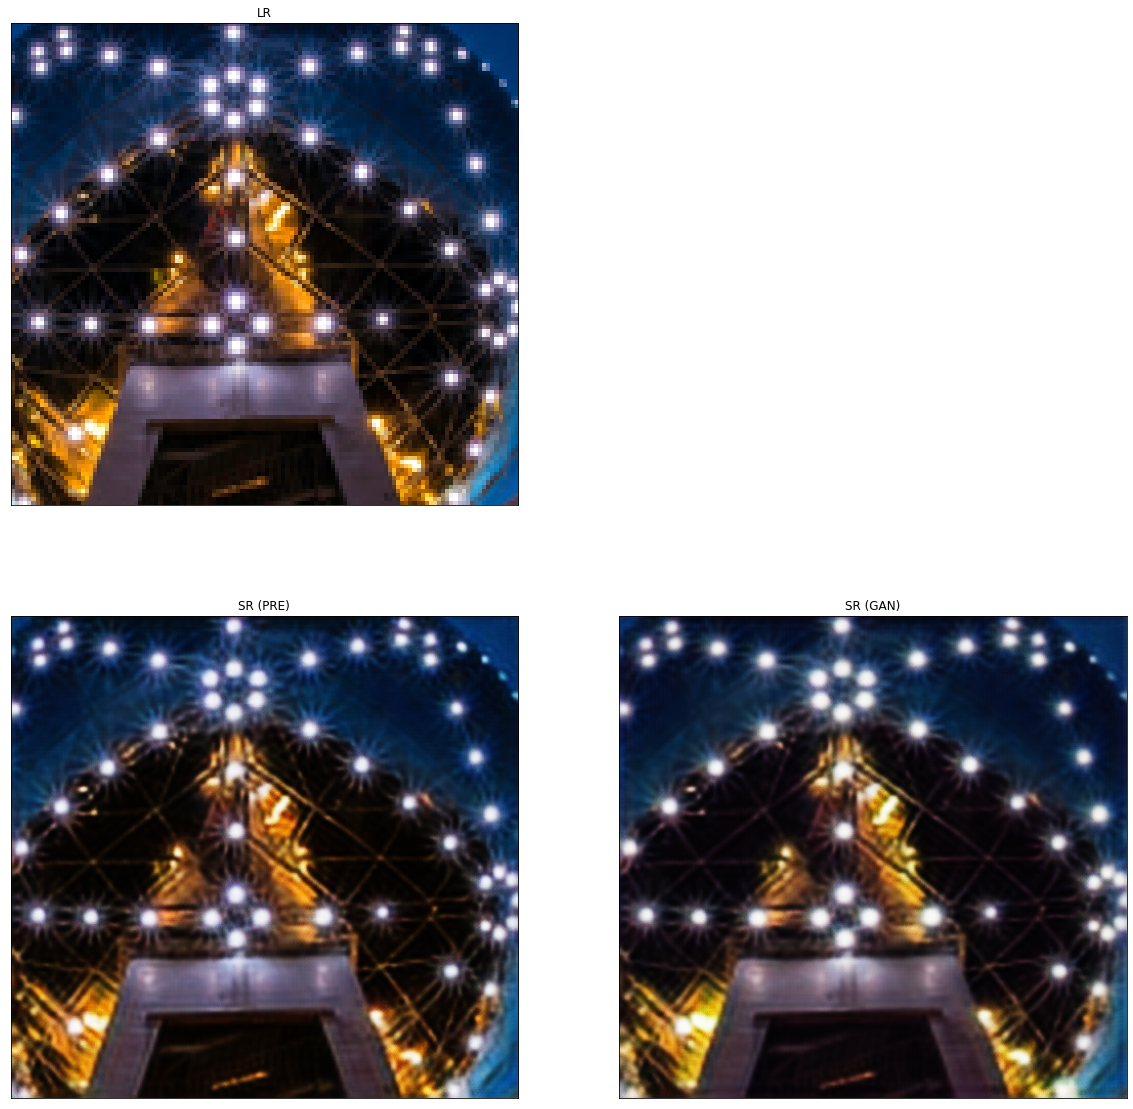

In [ ]:
resolve_and_plot('demo/0851x4-crop.png')

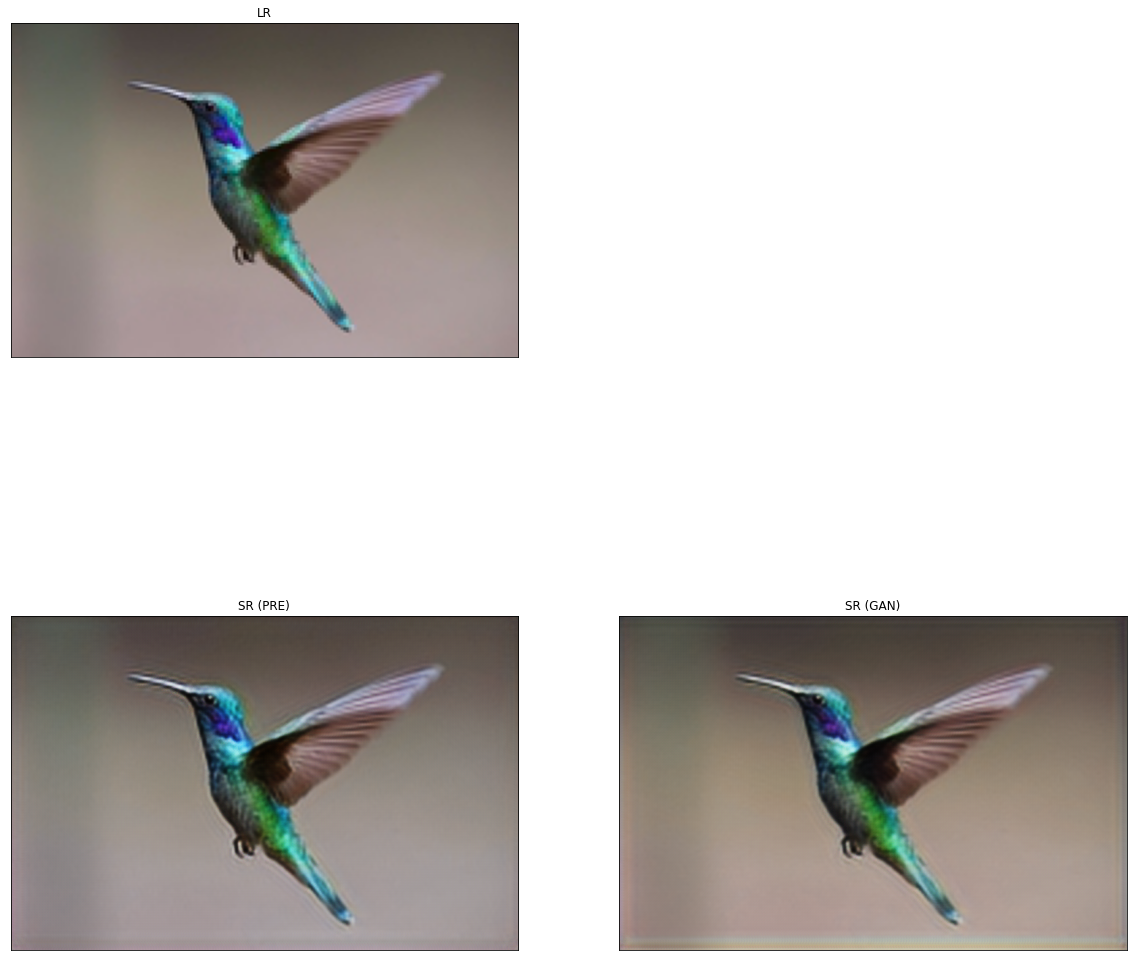

In [ ]:
resolve_and_plot('demo/birdsmall.jpg')


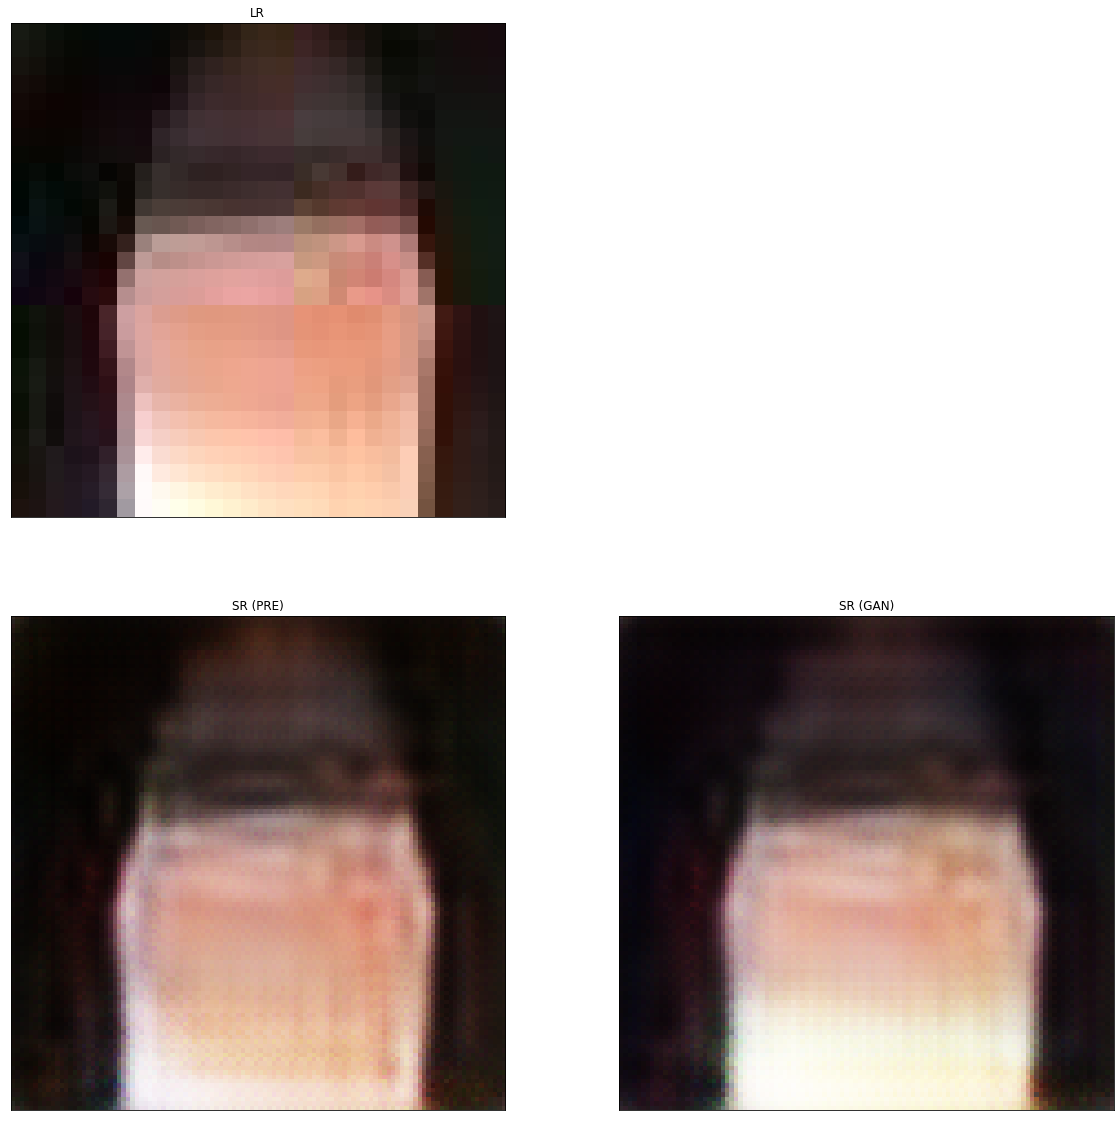

In [ ]:
resolve_and_plot('demo/resized1.jpeg')

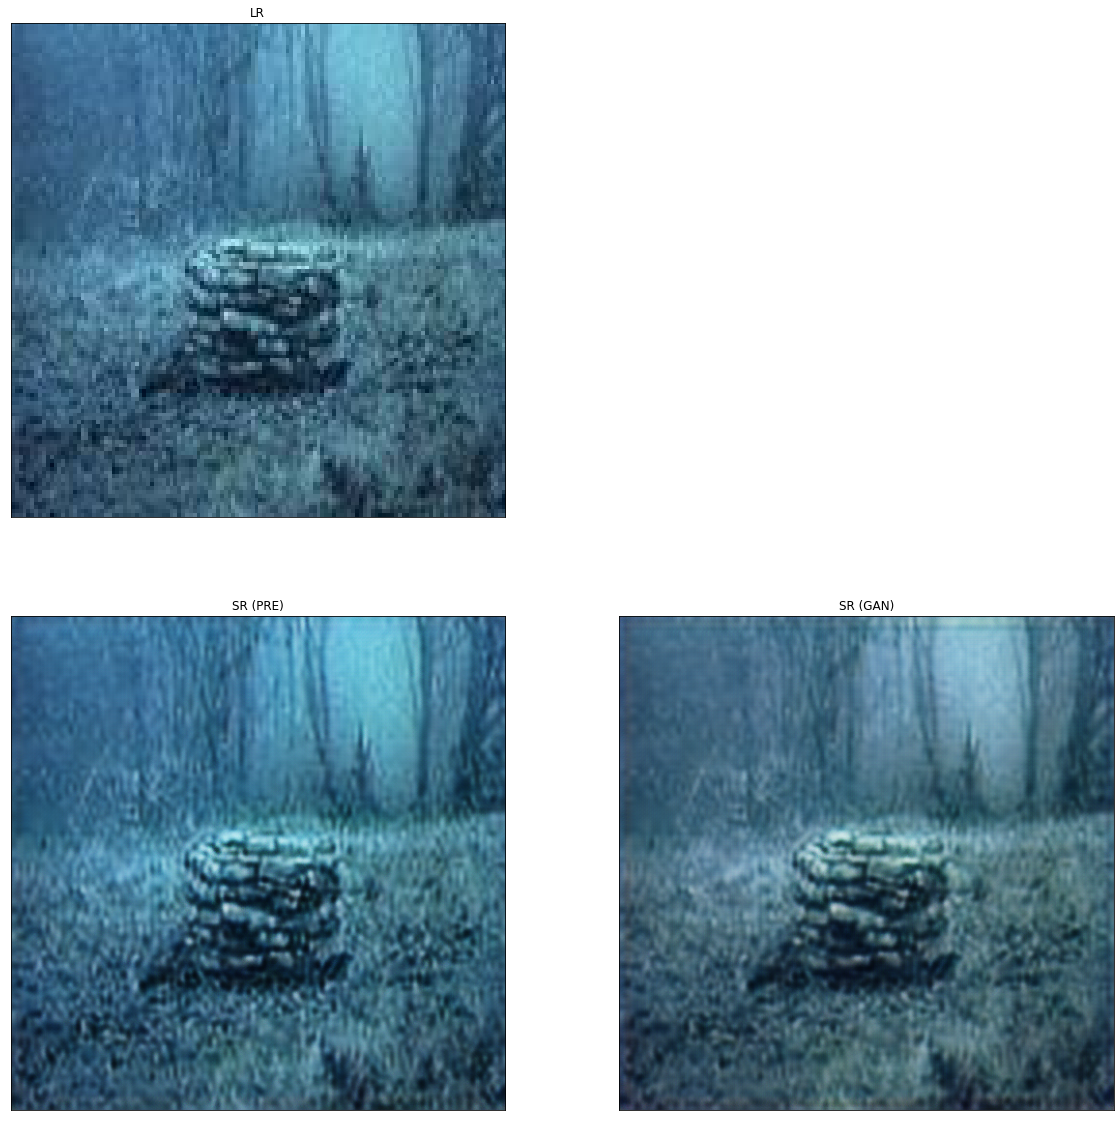

In [ ]:
resolve_and_plot('demo/ringu1.jpeg')